### Main objectives of notebook 

- Loading and exploring data 
- Checking for missing / presence of outliers 
- Generating basic visualisation plots

We import the necessary libraries; this requires the poetry environment to be set up, and set default plotting commands

In [3]:
import boto3
import warnings
import awswrangler as wr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tsfresh import extract_features 
from scipy import fftpack
from src.config import PATHS, KEYS

style_sheet = PATHS.MISC_DIR / "base.mplstyle"
plt.style.use(style_sheet)

%matplotlib inline

Connect to AWS Athena and query data

In [3]:
TRAINING_QUERY = f"""
    SELECT
        *,
        case when uuid like '%_walk_%' then true else false end as target
    FROM
        "smu-iot"."microbit"
    WHERE
        seconds IS NOT null
      AND uuid IN ('clarence_walk_1', 'licheng_situps_1', 'luna_ankle', 'luna_collar', 
                   'songhan_bagstroll_1', 'licheng_situps_1', 'licheng_walk_1', 'licheng_shaking_1', 
                   'licheng_box_1', 'songhan_walk_1', 'spencer_walk_1', 'songhan_fan_1')
    ORDER BY
        uuid, timestamp, seconds
"""

In [3]:
session = boto3.setup_default_session(
    region_name=KEYS.AWS_DEFAULT_REGION,
    aws_access_key_id=KEYS.AWS_ACCESS_KEY_ID,
    aws_secret_access_key=KEYS.AWS_SECRET_ACCESS_KEY,
)

step_counter_readings = wr.athena.read_sql_query(
    sql=TRAINING_QUERY,
    database="smu-iot"
)

How does walking vs non-walking data look like ? We need to visualise a total of 6 axis

* `accel-x`
* `accel-y`
* `accel-z`
* `gyro-x`
* `gyro-y`
* `gyro-z`

In [7]:
quantitative_vars = ['gyro_x', 'gyro_y', 'gyro_z', 'accel_x', 'accel_y', 'accel_z']

Extract the session for one instance of walking data

In [4]:
step_counter_readings = pd.read_csv(PATHS.DATA_DIR / "test.csv")

In [6]:
walking_series = step_counter_readings.query("uuid == 'songhan_walk_1'")

The accelerometer's readings show periodic cycles that are associated with the user's gait

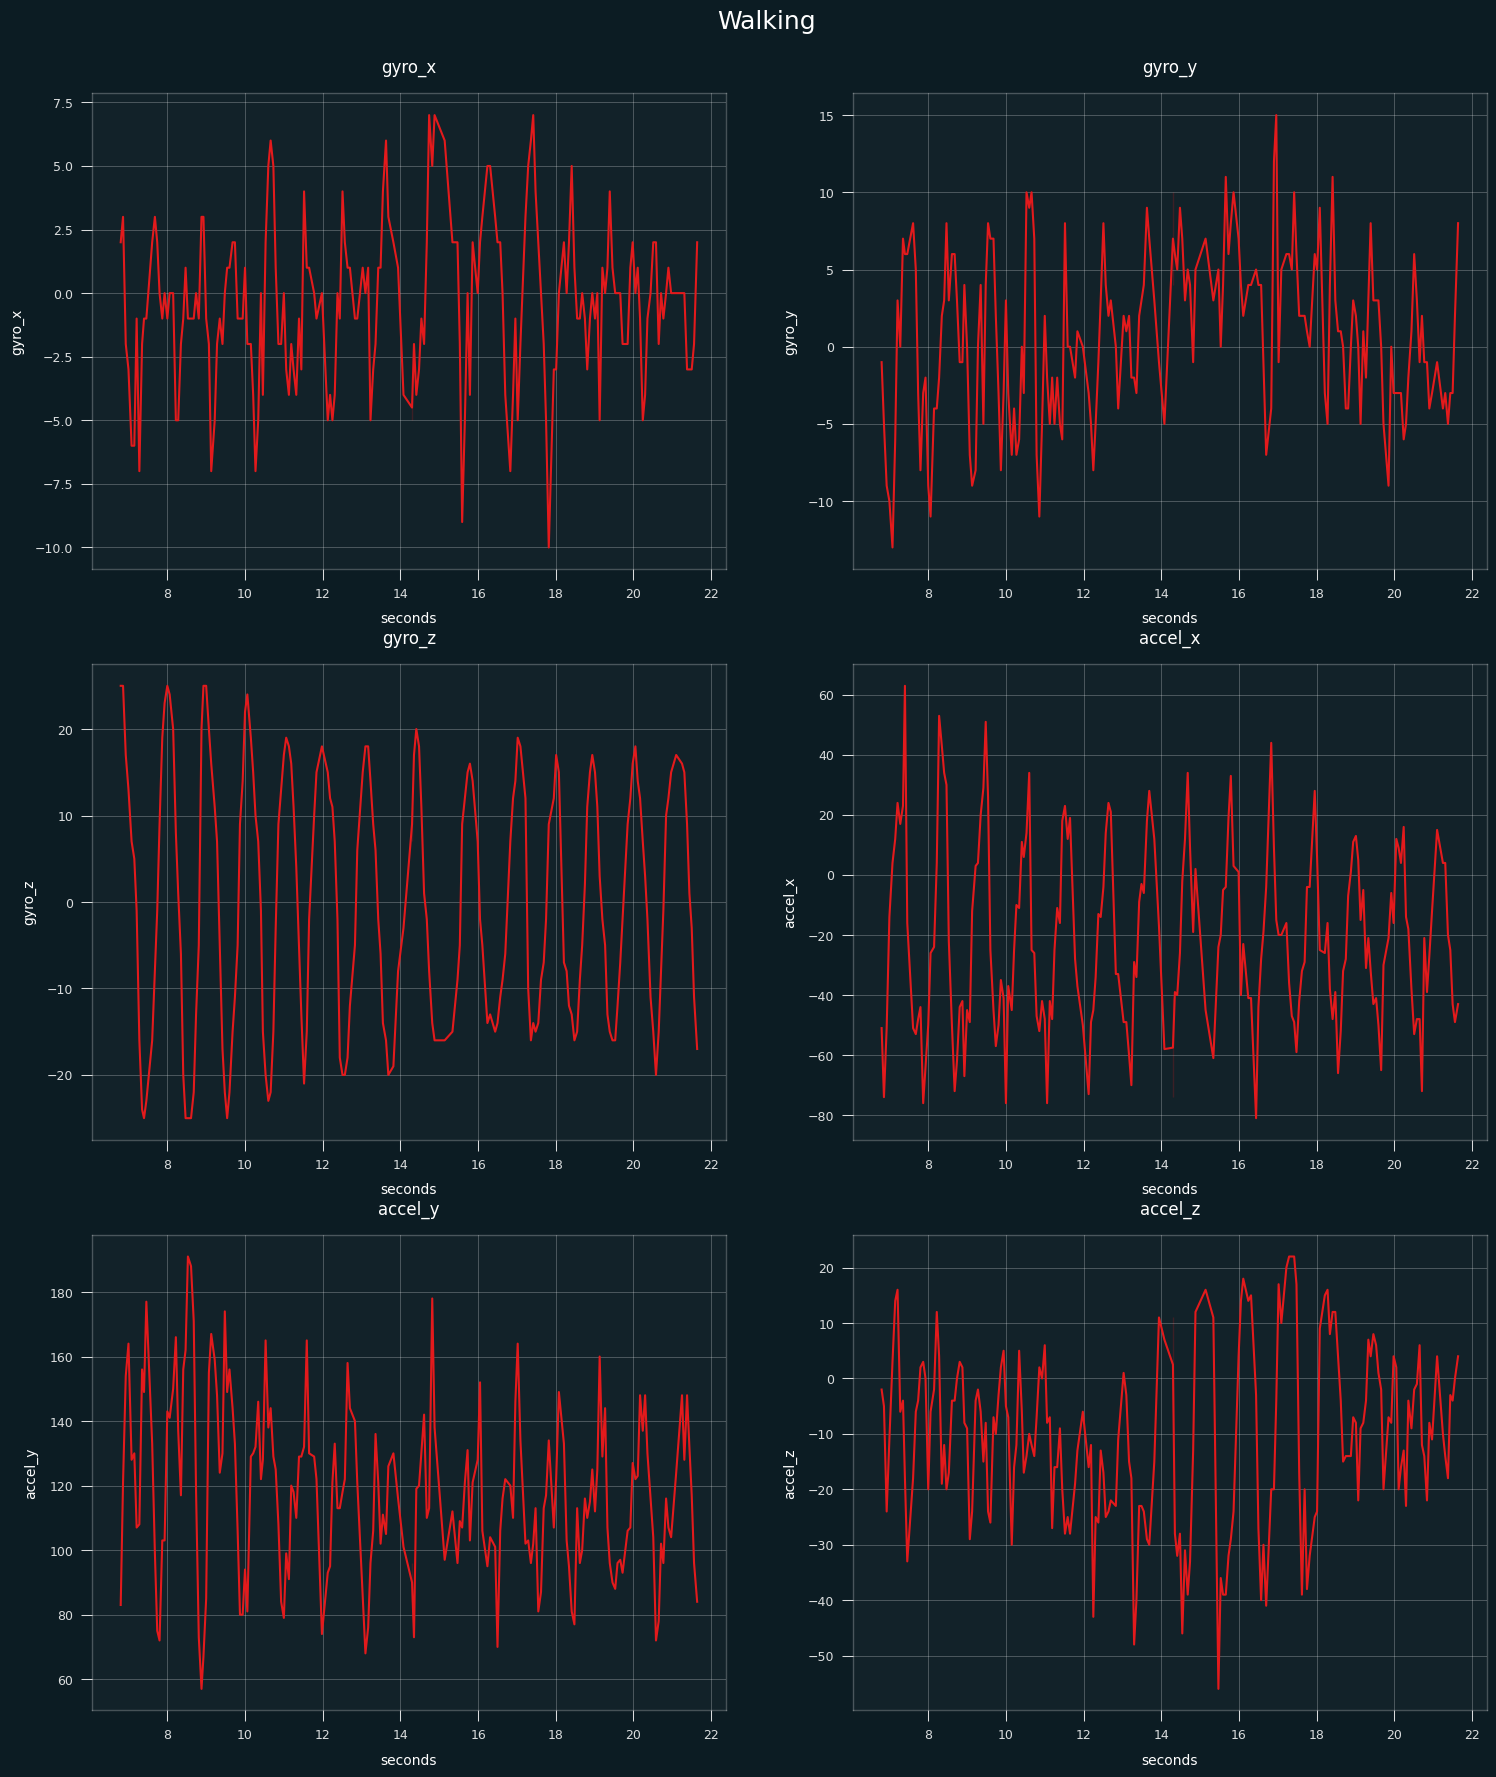

In [7]:
fig = plt.figure(figsize=(18, 21))

for idx, item in enumerate(quantitative_vars):
    ax = fig.add_subplot(3, 2, idx + 1)
    ax.set_title(item)
    sns.lineplot(
        data=walking_series[100:300], 
        x="seconds", 
        y=item, 
        ax=ax,
        color=sns.color_palette()[0]
    )
plt.suptitle("Walking", y=0.92, fontsize=18)
plt.show()

This periodic characteristic is notably absent in non-walking data

In [5]:
non_walking_series = step_counter_readings.query("uuid == 'licheng_situps_1'")

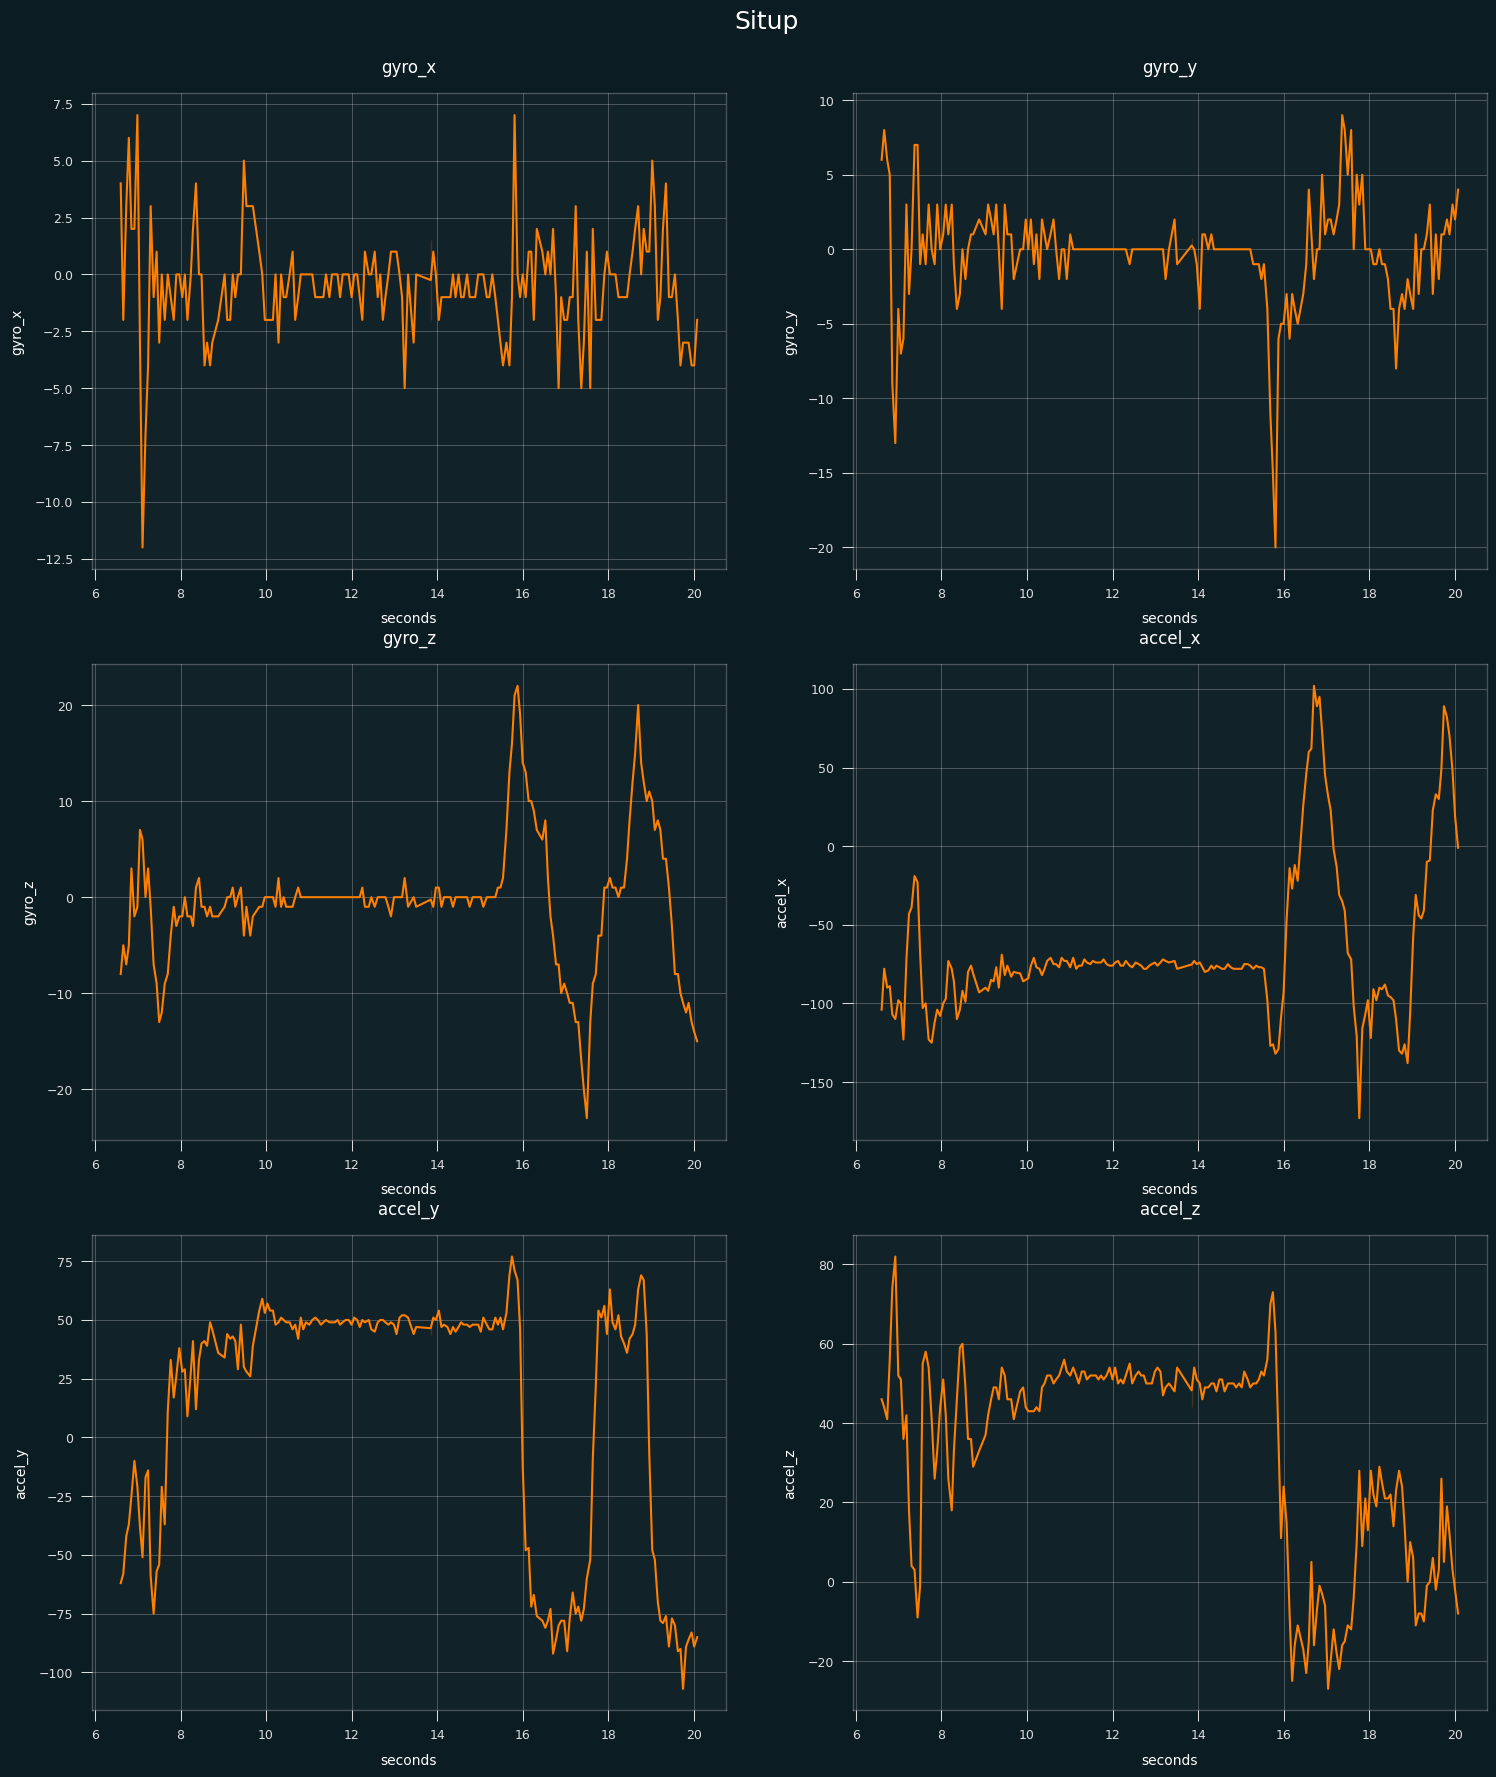

In [8]:
fig = plt.figure(figsize=(18, 21))

for idx, item in enumerate(quantitative_vars):
    ax = fig.add_subplot(3, 2, idx + 1)
    ax.set_title(item)
    sns.lineplot(
        data=non_walking_series[100:300], 
        x="seconds", 
        y=item, 
        ax=ax,
        color=sns.color_palette()[2]
    )
plt.suptitle("Situp", y=0.92, fontsize=18)
plt.show() 

Attaching the device to a fan results in flat readings for the gyroscope

In [9]:
fan_attachment_series = step_counter_readings.query("uuid == 'songhan_fan_1'")

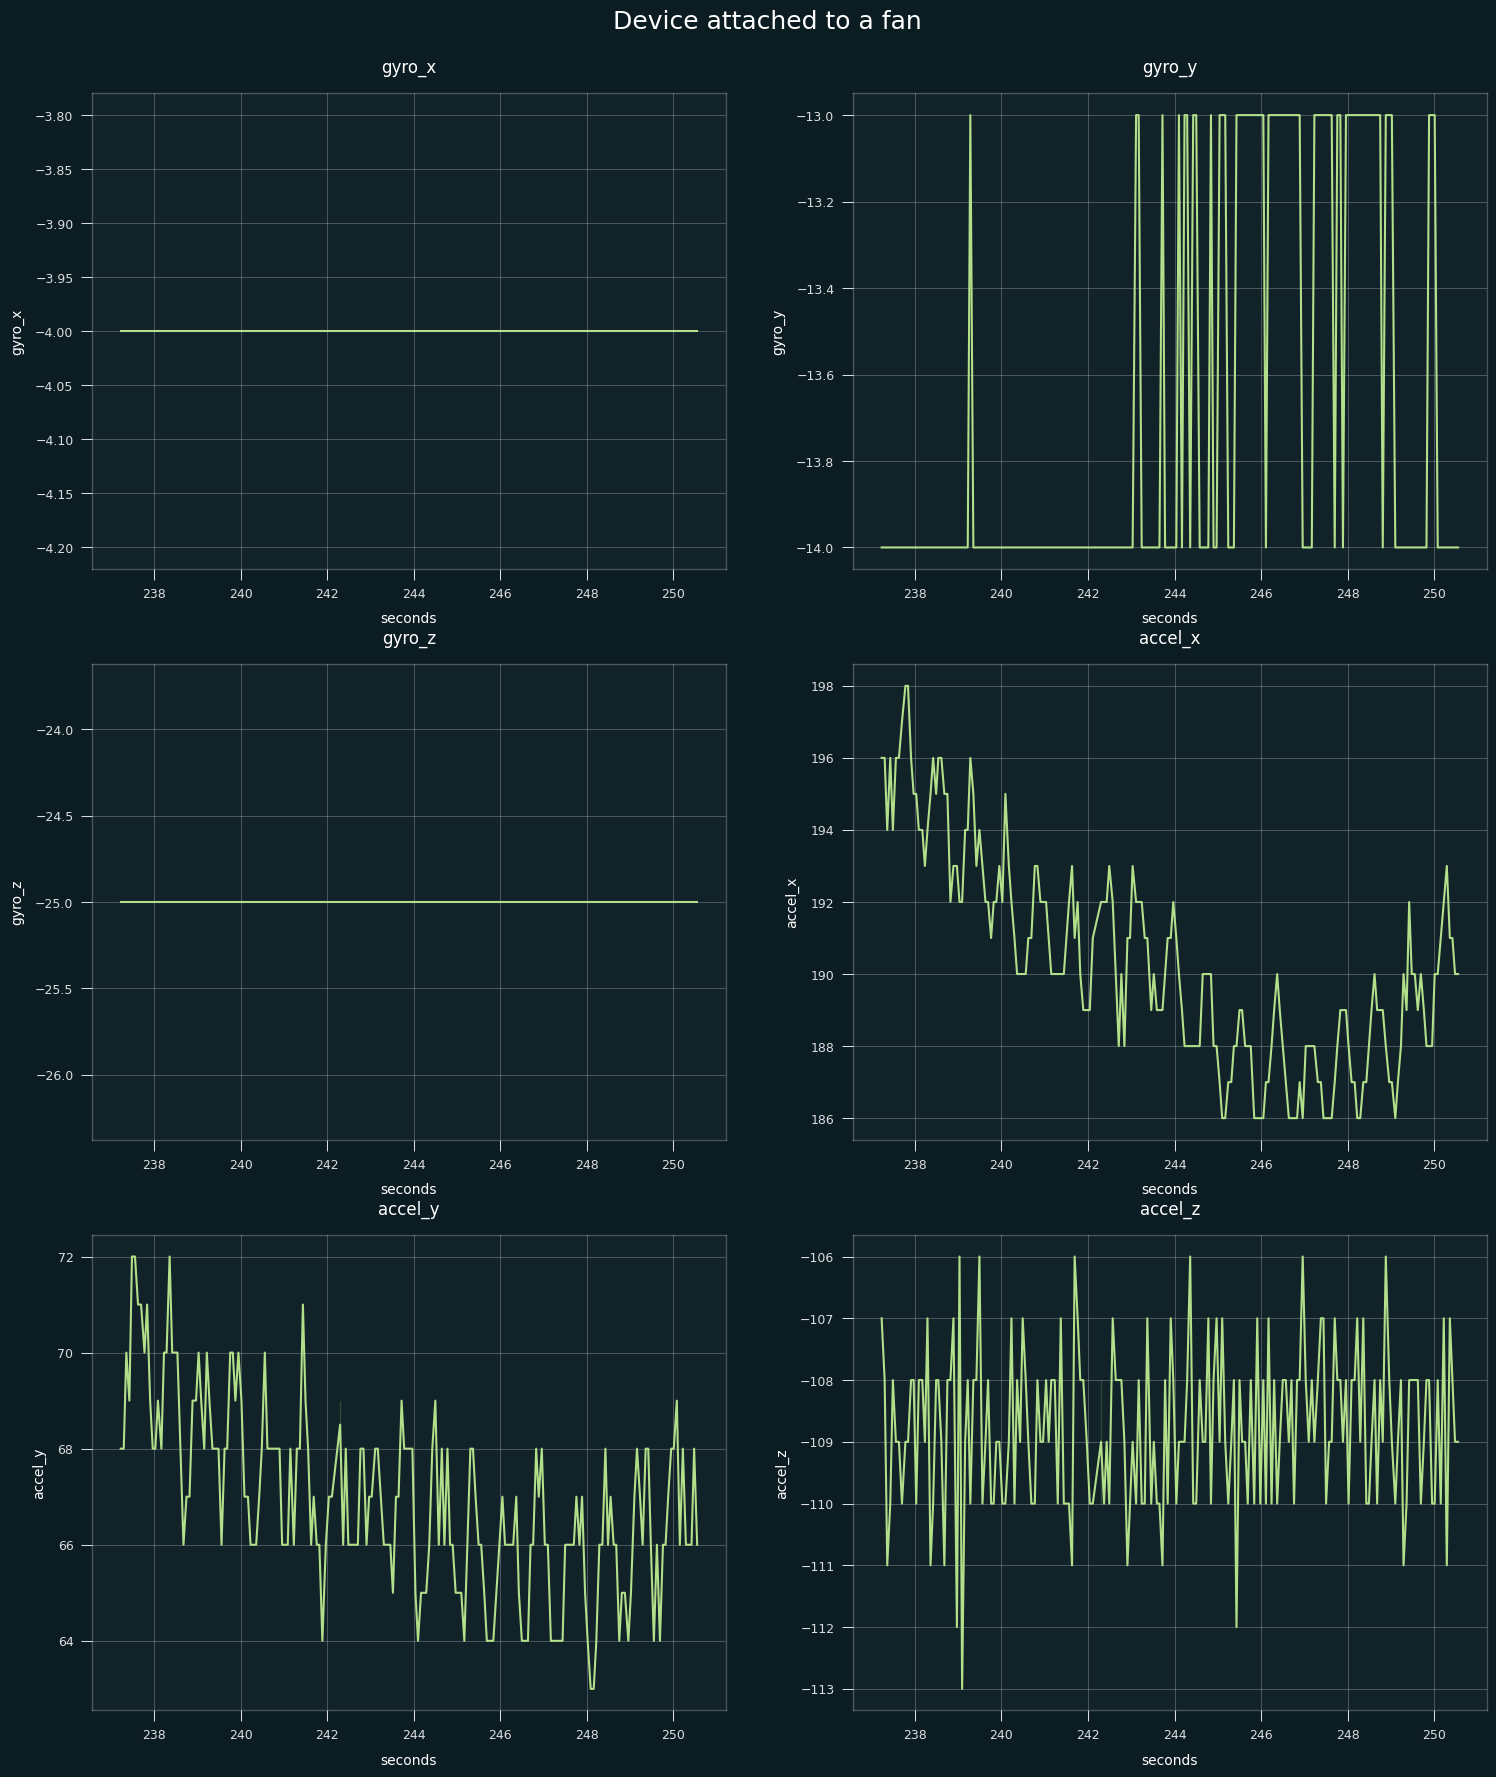

In [10]:
fig = plt.figure(figsize=(18, 21))

for idx, item in enumerate(quantitative_vars):
    ax = fig.add_subplot(3, 2, idx + 1)
    ax.set_title(item)
    sns.lineplot(
        data=fan_attachment_series[100:300], 
        x="seconds", 
        y=item, 
        ax=ax,
        color=sns.color_palette()[6]
    )
plt.suptitle("Device attached to a fan", y=0.92, fontsize=18)
plt.show() 

We note that the readings still appear relatively cyclical even when the microbit device is placed inside a bag and walking 

In [11]:
bagstroll_series = step_counter_readings.query("uuid == 'songhan_bagstroll_1'")

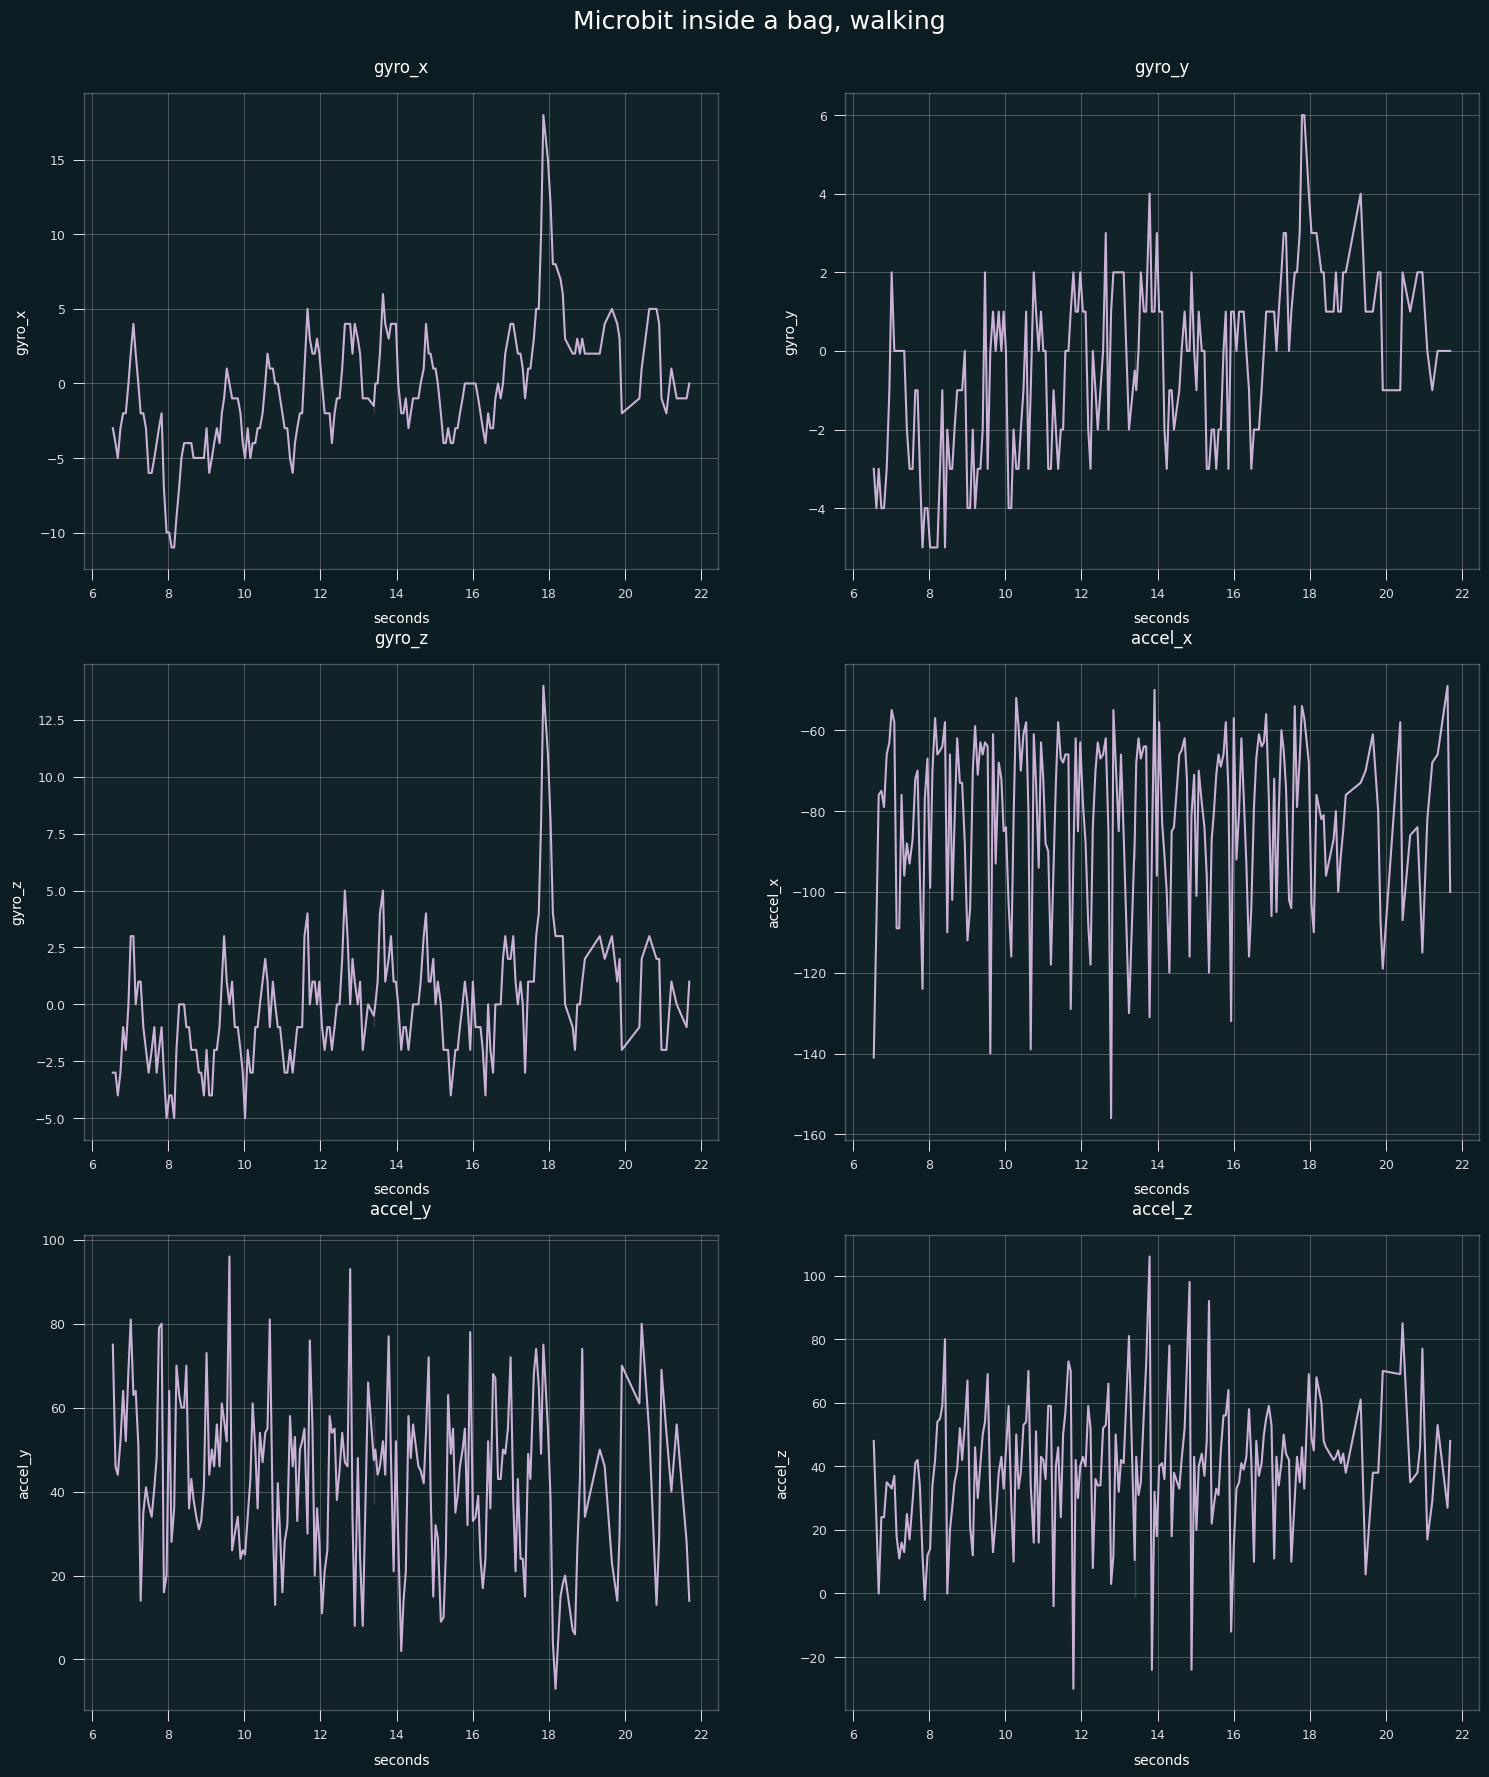

In [12]:
fig = plt.figure(figsize=(18, 21))

for idx, item in enumerate(quantitative_vars):
    ax = fig.add_subplot(3, 2, idx + 1)
    ax.set_title(item)
    sns.lineplot(
        data=bagstroll_series[100:300], 
        x="seconds", 
        y=item, 
        ax=ax,
        color=sns.color_palette()[9]
    )
plt.suptitle("Microbit inside a bag, walking", y=0.92, fontsize=18)
plt.show() 

We need to apply preprocessing operations and time series features extraction over a window period. To do so, we first need to determine an appropriate time interval for window operation.

Let's take a look at one of the variables - `gyro_z`.

From the graph below, we know that one period of step takes around 1 second. A brief estimation for an appropriate window period should cover at least several periods. 

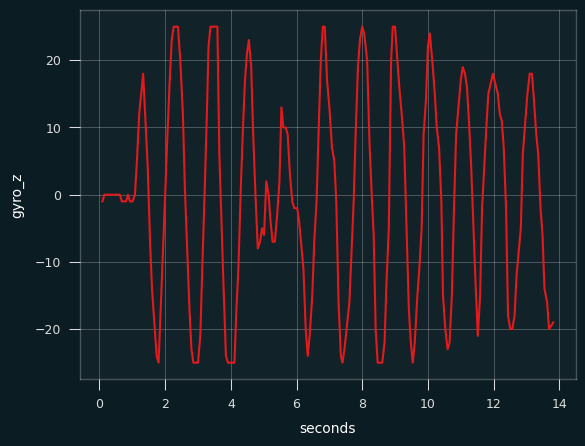

In [13]:
_ = sns.lineplot(data=step_counter_readings.query("uuid == 'songhan_walk_1'")[:200], x="seconds", y="gyro_z")

We can apply a Fourier Transformation on our data to examine the differences in the power spectrum for Walking vs Non Walking activities

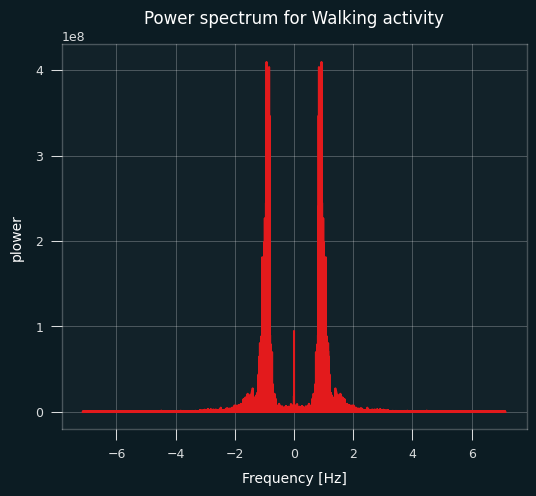

In [14]:
sig_fft = fftpack.fft(step_counter_readings[step_counter_readings["uuid"].str.contains('walk')]['gyro_z'].values)

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft) ** 2
sample_freq = fftpack.fftfreq(len(step_counter_readings[step_counter_readings["uuid"].str.contains('walk')]), d=0.07)

plt.figure(figsize=(6, 5))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
_ = plt.ylabel('plower')
_ = plt.title('Power spectrum for Walking activity')

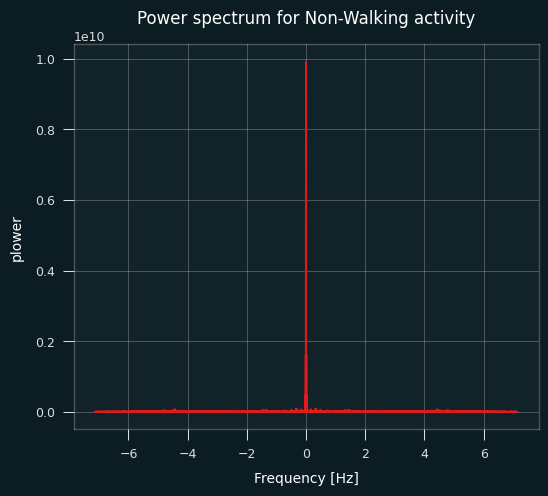

In [15]:
sig_fft = fftpack.fft(step_counter_readings[~step_counter_readings["uuid"].str.contains("walk")]["gyro_z"].values)

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft) ** 2
sample_freq = fftpack.fftfreq(len(step_counter_readings[~step_counter_readings["uuid"].str.contains("walk")]), d=0.07)

plt.figure(figsize=(6, 5))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
_ = plt.ylabel('plower')
_ = plt.title('Power spectrum for Non-Walking activity')

The fourier analysis reveals that the typical cycle period for walking activity is about 1 Hz, or a 1 sec period. 

We propose to use a `time_window` period of **4 seconds** in order to capture several cyle periods.

In [16]:
step_counter_readings[["seconds"]].diff(periods=1).describe()

,seconds
count,58599.000000
mean,0.000081
std,4.544740
min,-299.380000
25%,0.060000
50%,0.070000
75%,0.070000
max,19.890000


The median of time interval between each data record is 0.07 seconds. We approximate this to be **n = 57** for each time window.

In [17]:
window_n = 57

We can then process our features using the time-series feature extractor from TS fresh